# Projeto 3 - Ciência dos Dados

#  Projeto UFC

Nome: Victor Vergara Arcoverde de Albuquerque Cavalcanti

Nome: Edgard Neto

Nome: Gabriel Yamashita

Nome: Henrique Mualem Marti



  ___
## Objetivo:

### O objetivo desse projeto é fazer um machine learning para poder prever qual lutador ganhará uma luta do UFC baseado no seu histórico. Para isso serão usados os dados de todas as lutas do UFC (mais de 5 mil) a fim de descobrir quais os fatores dos lutadores que impactam mais no resultado das lutas. 

[Database utilizado](https://www.kaggle.com/rajeevw/ufcdata#data.csv)

____
## Método escolhido:






### Random Forest:
#### Esse método usa várias árvores de decisão para encontrar o que melhor se adequa, a que tem menos erros, para os nossos dados e o resultado que queremos, nesse caso qual é o vencedor.

![randomforest.png](randomforest.png)


___
### Regressão Logística:
#### Esse método usa a função abaixo que vai sempre tender a 0 ou a 1, assim sendo um classificador binário. Ele atribui um coeficiente(β) para cada fator levado em consideração, assim tendo uma ordem de impacto dos fatores no resultado final.

$$Prob(y = 1 | X = x) = \frac{1}{1 + e^{-\left(\beta_0 + \beta_1 x_1 + \beta_2 x_2\right)}}$$

 ___
## Preparando o ambiente no jupyter:

___
### Imports:

In [2]:
import math
import os.path
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import random
import statsmodels.api as sm
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

___
### Trabalhando com os Excels:

In [92]:
data = pd.read_excel("data.xlsx")
data2 = data
data.head(2)

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,no_of_rounds,B_current_lose_streak,...,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Henry Cejudo,Marlon Moraes,Marc Goddard,2019,"Chicago, Illinois, USA",Red,True,Bantamweight,5,0,...,2,0,0,8,Orthodox,162.56,162.56,135.0,31.0,32.0
1,Valentina Shevchenko,Jessica Eye,Robert Madrigal,2019,"Chicago, Illinois, USA",Red,True,Women's Flyweight,5,0,...,0,2,0,5,Southpaw,165.10,167.64,125.0,32.0,31.0


In [73]:
data.weight_class = data.weight_class.astype('category')
data.Winner = data.Winner.astype('category')

### Análise exploratória
#### Explorando o dataframe inicial

In [74]:
data.Winner.value_counts()

Red     3470
Blue    1591
Draw      83
Name: Winner, dtype: int64

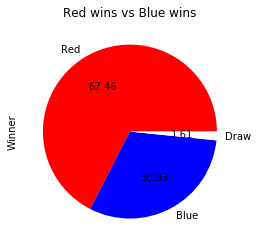

In [156]:
plt.title("Red wins vs Blue wins")
data.Winner.value_counts().plot(kind='pie', colors=['red','blue','white'], autopct="%0.2f",legend=False);

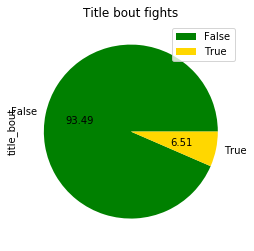

In [155]:
plt.title("Title bout fights")
data['title_bout'].value_counts().plot(kind='pie', colors=['green','gold'],autopct="%0.2f",legend=True);

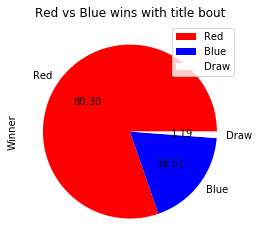

In [152]:
graf_winner_with_title = data.loc[: , ["Winner", "title_bout"]]
graf_winner_with_title1 = graf_winner_with_title.loc[(graf_winner_with_title.title_bout==True),:]
plt.title("Red vs Blue wins with title bout")
graf_winner_with_title1.Winner.value_counts().plot(kind='pie', colors=['red','blue',"white"],autopct="%0.2f",legend=True);  

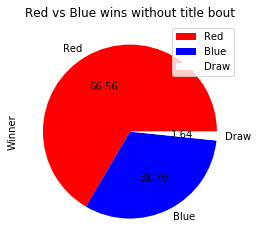

In [151]:
graf_winner_with_title = data.loc[: , ["Winner", "title_bout"]]
graf_winner_with_title1 = graf_winner_with_title.loc[(graf_winner_with_title.title_bout==False),:]
plt.title("Red vs Blue wins without title bout")
graf_winner_with_title1.Winner.value_counts().plot(kind='pie', colors=['red','blue',"white"],autopct="%0.2f",legend=True);

False

In [24]:
data_heavy = data.loc[(data.weight_class=='Heavyweight'),:]
bool_to_number = {False: 0, True: 1}
string_to_number = {'Blue': 0, 'Red': 1, 'Draw': 2}
data_heavy['title_bout'] = data_heavy['title_bout'].map(bool_to_number)
data_heavy['Winner'] = data_heavy['Winner'].map(string_to_number)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


#### Blue = 0
#### Red = 1

In [25]:
data_heavy.head(2)

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,no_of_rounds,B_current_lose_streak,...,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
4,Tai Tuivasa,Blagoy Ivanov,Dan Miragliotta,2019,"Chicago, Illinois, USA",0,0,Heavyweight,3,0,...,2,0,0,3,Southpaw,187.96,190.50,264.0,32.0,26.0
54,Walt Harris,Serghei Spivac,Jerin Valel,2019,"Ottawa, Ontario, Canada",1,0,Heavyweight,3,0,...,4,0,0,4,Southpaw,195.58,195.58,250.0,24.0,35.0


In [26]:
data_heavy_util = data_heavy.drop(['Referee','date','location'], axis=1)
#dados que não se relacionam com os lutadores ou seus resultado

In [27]:
data_heavy_util.head(2)

,R_fighter,B_fighter,Winner,title_bout,weight_class,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,...,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
4,Tai Tuivasa,Blagoy Ivanov,0,0,Heavyweight,3,0,1,0,17.0,...,2,0,0,3,Southpaw,187.96,190.50,264.0,32.0,26.0
54,Walt Harris,Serghei Spivac,1,0,Heavyweight,3,0,0,0,NaN,...,4,0,0,4,Southpaw,195.58,195.58,250.0,24.0,35.0


In [28]:
data_heavy_util.dropna(inplace=True)
data_heavy_util.head(2)

,R_fighter,B_fighter,Winner,title_bout,weight_class,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,...,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
4,Tai Tuivasa,Blagoy Ivanov,0,0,Heavyweight,3,0,1,0,17.0,...,2,0,0,3,Southpaw,187.96,190.5,264.0,32.0,26.0
60,Arjan Bhullar,Juan Adams,1,0,Heavyweight,3,0,1,0,8.0,...,0,0,0,2,Orthodox,185.42,190.5,245.0,27.0,32.0


___
### Tirando os dados categóricos:

In [29]:
categoricas = [
    'R_fighter', 
    'B_fighter', 
    'weight_class', 
    'R_Stance', 
    'B_Stance', 
]

data_heavy_cat = data_heavy_util[categoricas].astype('category')
data_heavy_num = data_heavy_util.drop(categoricas, axis=1).astype('float')

## Teste temporário   ARRUMAR DEPOIS

In [30]:
teste_x=data_heavy_num.loc[:,['B_current_lose_streak','B_current_win_streak','R_current_lose_streak','R_current_win_streak']]
teste_y=data_heavy_num['Winner']

In [31]:
X_Train, X_Test, y_Train, y_Test = train_test_split(teste_x, teste_y, test_size=0.25)
model = RandomForestClassifier(n_estimators=10000)

model.fit(X_Train, y_Train)
y_Pred = model.predict(X_Test)

print(accuracy_score(y_Test, y_Pred))

0.6060606060606061


___
# Teste 1 - Random Forest

In [32]:
X = data_heavy_num.drop('Winner', axis=1)
y = data_heavy_num['Winner']

## Separando os dados em testes e treinamento

In [33]:
X_train_random, X_test_random, y_train_random, y_test_random = train_test_split(X, y, test_size=0.25)

___
## Montando modelo Random Forest

In [34]:
model_random = RandomForestClassifier(n_estimators=10000)

model_random.fit(X_train_random, y_train_random)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

___
## Verificando a performance


In [35]:
X_train_random.columns

Index(['title_bout', 'no_of_rounds', 'B_current_lose_streak',
       'B_current_win_streak', 'B_draw', 'B_avg_BODY_att', 'B_avg_BODY_landed',
       'B_avg_CLINCH_att', 'B_avg_CLINCH_landed', 'B_avg_DISTANCE_att',
       ...
       'R_win_by_Decision_Unanimous', 'R_win_by_KO/TKO', 'R_win_by_Submission',
       'R_win_by_TKO_Doctor_Stoppage', 'R_wins', 'R_Height_cms', 'R_Reach_cms',
       'R_Weight_lbs', 'B_age', 'R_age'],
      dtype='object', length=136)

In [36]:
model_random.feature_importances_

array([0.00039842, 0.0007982 , 0.00316457, 0.00292289, 0.        ,
       0.01272663, 0.01183135, 0.00808746, 0.00837056, 0.00992644,
       0.00946308, 0.00878109, 0.00937581, 0.01026415, 0.00900936,
       0.00564233, 0.00943604, 0.00840461, 0.00681294, 0.00541592,
       0.00961443, 0.00836938, 0.00812098, 0.00486232, 0.00917926,
       0.00623138, 0.00613686, 0.01020084, 0.00895179, 0.0037845 ,
       0.00357768, 0.00935141, 0.01025392, 0.00769637, 0.00771841,
       0.00805765, 0.00853123, 0.01087959, 0.01068599, 0.00859753,
       0.0083359 , 0.00436722, 0.01110645, 0.00895094, 0.00718057,
       0.00407678, 0.00933084, 0.0077914 , 0.0088473 , 0.00606731,
       0.00652738, 0.0056491 , 0.00631335, 0.01003571, 0.01287625,
       0.00606956, 0.007096  , 0.00157905, 0.00050798, 0.00104345,
       0.0027865 , 0.00426653, 0.0017338 , 0.00028288, 0.0038011 ,
       0.00534477, 0.00839953, 0.00821804, 0.00292261, 0.00428449,
       0.        , 0.00820921, 0.0074974 , 0.00907138, 0.00814

In [37]:
y_pred_random = model_random.predict(X_test_random)

In [38]:
print(accuracy_score(y_test_random, y_pred_random))

0.5757575757575758


In [39]:
y_pred_random

array([1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
       0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.])

In [40]:
y_test_random.value_counts(True)

1.0    0.590909
0.0    0.409091
Name: Winner, dtype: float64

In [41]:
data_heavy_num.Winner.value_counts()

1.0    167
0.0     92
2.0      5
Name: Winner, dtype: int64

   ___
## Conclusão do Modelo inicial Random Forest:

Tendo um acurácia de 0.6667 não é um bom resultado, visto que o modelo praticamente sempre tem como resultado o vermelho como vencedor, e como a probabilidade do lutador vermelho ganhar é de 0.6212112 ele praticamente só acerta os que o vencedor é o vermelho e erra os que o azul é o vencedor.

Assim é possível concluir que é necessário desconsiderar algumas variáveis para melhorar a acurácia.

   ___
## Criando um dataframe dos fatores mais impactantes no resultado segundo o teste acima:

In [47]:
#Fatores que tem o maior peso na decisão da vitória
j=1
lista_j=list()
for i, f in sorted(list(zip(model_random.feature_importances_, X_train_random.columns)), reverse=True):
    a=str(j)+'°'
    lista_j.append(a)
    j+=1

In [48]:
data={'Fator':X_train_random.columns ,'Correlação':model_random.feature_importances_,}
Fator_por_corr=pd.DataFrame(data)
Fator_por_corr=Fator_por_corr.sort_values(by='Correlação', ascending=False)
Fator_por_corr['Grau de Importância']=lista_j
Fator_por_corr = Fator_por_corr.set_index('Grau de Importância')
Fator_por_corr.head(2)

,Fator,Correlação
Grau de Importância,,
1°,R_age,0.018546
2°,R_avg_opp_TOTAL_STR_landed,0.013475


In [53]:
data_heavy_util_relevante = data_heavy_util.loc[:,uteis]
data_heavy_util_relevante.head(2)

,Winner,R_age,R_avg_opp_TOTAL_STR_landed,R_avg_opp_CLINCH_landed,R_avg_opp_GROUND_att,R_losses,B_avg_opp_TOTAL_STR_landed,B_avg_BODY_att,R_total_rounds_fought,R_avg_opp_GROUND_landed,...,B_avg_opp_GROUND_att,B_avg_opp_GROUND_landed,R_avg_TD_pct,B_avg_HEAD_att,B_avg_opp_BODY_landed,B_avg_TOTAL_STR_att,R_avg_opp_BODY_landed,R_avg_opp_SIG_STR_landed,R_avg_TOTAL_STR_att,B_avg_opp_TOTAL_STR_att
4,0,26.0,27.750000,3.500000,7.750000,1,90.0,17.0,7,2.750000,...,0.0,0.0,0.00,184.5,23.5,204.0,4.750000,22.500000,63.500000,205.5
60,1,32.0,42.333333,5.333333,1.333333,1,46.0,8.0,8,0.666667,...,2.0,2.0,0.72,131.0,10.0,180.0,7.666667,29.333333,98.666667,81.0


   ___
## Escolhendo quais dados devem ser usados nos modelos de predição:

In [50]:
def relevancia(df,coluna_nome,coluna_correlacao,acuracia):
    inuteis = []
    uteis = ['Winner']
    for index,row in df.iterrows():
        if row[coluna_correlacao] >= -acuracia and row[coluna_correlacao] <= acuracia:
            inuteis.append(row[coluna_nome])
        else:
            uteis.append(row[coluna_nome])
    return uteis

In [51]:
uteis = relevancia(Fator_por_corr,'Fator','Correlação',0.01)

In [52]:
data_heavy_util_relevante = data_heavy_util.loc[:,uteis]
data_heavy_util_relevante.head()

,Winner,R_age,R_avg_opp_TOTAL_STR_landed,R_avg_opp_CLINCH_landed,R_avg_opp_GROUND_att,R_losses,B_avg_opp_TOTAL_STR_landed,B_avg_BODY_att,R_total_rounds_fought,R_avg_opp_GROUND_landed,...,B_avg_opp_GROUND_att,B_avg_opp_GROUND_landed,R_avg_TD_pct,B_avg_HEAD_att,B_avg_opp_BODY_landed,B_avg_TOTAL_STR_att,R_avg_opp_BODY_landed,R_avg_opp_SIG_STR_landed,R_avg_TOTAL_STR_att,B_avg_opp_TOTAL_STR_att
4,0,26.0,27.750000,3.500000,7.750000,1,90.000,17.00,7,2.750000,...,0.000,0.00,0.000000,184.5,23.5,204.00,4.750000,22.500000,63.500000,205.500
60,1,32.0,42.333333,5.333333,1.333333,1,46.000,8.00,8,0.666667,...,2.000,2.00,0.720000,131.0,10.0,180.00,7.666667,29.333333,98.666667,81.000
63,1,30.0,16.000000,1.000000,3.000000,1,58.000,5.00,2,3.000000,...,28.500,14.50,0.000000,15.5,2.0,65.00,0.000000,12.000000,70.000000,115.500
69,0,40.0,34.821429,3.035714,7.964286,12,84.000,35.00,59,5.357143,...,0.000,0.00,0.128571,169.0,24.0,233.00,3.750000,22.321429,74.250000,183.000
75,1,38.0,28.533333,4.200000,4.133333,6,31.125,4.25,29,3.466667,...,3.625,2.75,0.200000,28.5,3.5,58.25,3.533333,18.933333,51.600000,52.375


___
# Teste 2- Regressão Logística

___
## Montando a Regressão Logística


## !Ainda é necessário tirar os fatores que foram julgados ter um baixo grau de importância pelo teste anterior!

In [54]:
def preparo(X,Y):
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp,missing='drop')
    results = model.fit()
    return results

In [55]:
Y_log = data_heavy_util_relevante["Winner"]
data_heavy_sem_Winner=data_heavy_util_relevante.drop('Winner',axis=1) 
X_log=data_heavy_sem_Winner
#np.asarray(X)

In [56]:
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, Y_log, test_size=0.25)

In [57]:
model = LogisticRegression(max_iter=200000,solver='lbfgs', multi_class='auto')

model.fit(X_train_log, y_train_log)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200000, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [58]:
y_pred_log = model.predict(X_test_log)

In [59]:
print(accuracy_score(y_test_log, y_pred_log))

0.5606060606060606


In [60]:
y_pred_log

array([1, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       0, 1, 1, 2, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 2, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1],
      dtype=int64)

In [61]:
y_test_log.value_counts(True)

1    0.606061
0    0.363636
2    0.030303
Name: Winner, dtype: float64

In [62]:
data_heavy_util_relevante.Winner.value_counts()

1    167
0     92
2      5
Name: Winner, dtype: int64

In [63]:
result = preparo(X_log,Y_log)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Winner   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.141
Date:                Tue, 19 Nov 2019   Prob (F-statistic):              0.302
Time:                        15:59:10   Log-Likelihood:                -182.48
No. Observations:                 264   AIC:                             413.0
Df Residuals:                     240   BIC:                             498.8
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.9992      0.306      3.265      0.001       0.396       1.602
R_age                         -0.0070      0.009     -0.733      0.464      -0.026       0.012
R_avg_opp_TOTAL_STR_landed    -0.0005      0.004     -0.134      0.894      -0.009       0.007
R_avg_opp_CLINCH_landed       -0.0070      0.037     -0.190      0.849      -0.080       0.066
R_avg_opp_GROUND_att           0.0068      0.021      0.321      0.748      -0.035       0.049
R_losses                      -0.0133      0.032     -0.410      0.682      -0.077       0.051
B_avg_opp_TOTAL_STR_landed     0.0044      0.005      0.919      0.359      -0.005       0.014
B_avg_BODY_att                 0.0029      0.026      0.112      0.911      -0.048       0.054
R_total_rounds_fought          0.0012      0.006      0.194      0.846      -0.011       0.014
R_avg_opp_GROUND_landed       -0.0136      0.031     -0.437      0.662      -0.075       0.048
R_avg_opp_CLINCH_att          -0.0074      0.027     -0.273      0.785      -0.060       0.046
B_avg_BODY_landed             -0.0167      0.032     -0.530      0.597      -0.079       0.046
R_avg_opp_HEAD_landed         -0.0083      0.015     -0.559      0.577      -0.037       0.021
B_avg_opp_LEG_att             -0.0027      0.012     -0.234      0.815      -0.026       0.020
B_avg_opp_GROUND_att          -0.0023      0.019     -0.123      0.902      -0.040       0.035
B_avg_opp_GROUND_landed       -0.0006      0.028     -0.021      0.984      -0.056       0.055
R_avg_TD_pct                   0.2047      0.152      1.344      0.180      -0.095       0.505
B_avg_HEAD_att                -0.0012      0.003     -0.405      0.686      -0.007       0.005
B_avg_opp_BODY_landed         -0.0034      0.009     -0.375      0.708      -0.021       0.014
B_avg_TOTAL_STR_att           -0.0012      0.002     -0.572      0.568      -0.005       0.003
R_avg_opp_BODY_landed         -0.0038      0.018     -0.214      0.830      -0.038       0.031
R_avg_opp_SIG_STR_landed       0.0056      0.014      0.406      0.685      -0.022       0.033
R_avg_TOTAL_STR_att            0.0013      0.001      0.962      0.337      -0.001       0.004
B_avg_opp_TOTAL_STR_att       -0.0004      0.003     -0.132      0.895      -0.006       0.005
==============================================================================
Omnibus:                        8.223   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                5.698
Skew:                          -0.225   Prob(JB):                       0.0579
Kurtosis:                       2.439   Cond. No.                     1.58e+03
==============================================================================

Warnings:
[1] Standard Errors assume that t

____
## Predição do modelo

___
## Conclusão

   ___
## Aperfeiçoamento:


   ___
## Referências

[Como usar a biblioteca Scikit-lear](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

[Como funciona o Random Forest](https://towardsdatascience.com/understanding-random-forest-58381e0602d2)

[Referencia do Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

[Como funciona regressão linear](https://www.saedsayad.com/logistic_regression.htm)

[Como usar a Regressão Linear](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)



In [64]:
#criando um novo dataframe
lista_locB = ["B_fighter", "weight_class","B_Height_cms","B_Reach_cms","B_Weight_lbs","B_age"]
lista_locR = ["R_fighter", "weight_class","R_Height_cms","R_Reach_cms","R_Weight_lbs","R_age"]
data_red = data2.loc[: , lista_locR]
data_blue = data2.loc[: , lista_locB]

data_blue.columns = ["Fighter","Weight_class","Height_cms","Reach_cms","Weight_lbs","Age"]
data_red.columns = ["Fighter","Weight_class","Height_cms","Reach_cms","Weight_lbs","Age"]

data_red.head(2)

,Fighter,Weight_class,Height_cms,Reach_cms,Weight_lbs,Age
0,Henry Cejudo,Bantamweight,162.56,162.56,135.0,32.0
1,Valentina Shevchenko,Women's Flyweight,165.10,167.64,125.0,31.0


In [65]:
newdataR = pd.DataFrame()


namelist = []

for n in range(0,5143):
    if data_red.loc[n,:]["Fighter"] not in namelist:
        namelist.append(data_red.loc[n,:]["Fighter"])
        newdataR = pd.concat([newdataR,data_red.loc[n,:]], axis=1, join='outer')

newdataR = newdataR.transpose()

newdataR.head(2)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


,Age,Fighter,Height_cms,Reach_cms,Weight_class,Weight_lbs
0,32,Henry Cejudo,162.56,162.56,Bantamweight,135
1,31,Valentina Shevchenko,165.1,167.64,Women's Flyweight,125


In [66]:
newdataB = pd.DataFrame()

namelist = []

for n in range(0,5143):
    if data_blue.loc[n,:]["Fighter"] not in namelist:
        namelist.append(data_blue.loc[n,:]["Fighter"])
        newdataB = pd.concat([newdataB,data_blue.loc[n,:]], axis=1, join='outer')

newdataB = newdataB.transpose()

newdataB.head(2)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,Age,Fighter,Height_cms,Reach_cms,Weight_class,Weight_lbs
0,31,Marlon Moraes,167.64,170.18,Bantamweight,135
1,32,Jessica Eye,167.64,167.64,Women's Flyweight,125


In [67]:
newdata = pd.concat([newdataB, newdataR], axis=0, join='outer', ignore_index=False, keys=None,levels=None, names=None, verify_integrity=False, copy=True)
newdata = newdata.set_index("Fighter")

newdata.head(2)

,Age,Height_cms,Reach_cms,Weight_class,Weight_lbs
Fighter,,,,,
Marlon Moraes,31,167.64,170.18,Bantamweight,135
Jessica Eye,32,167.64,167.64,Women's Flyweight,125


In [69]:
data

{'Fator': Index(['title_bout', 'no_of_rounds', 'B_current_lose_streak',
        'B_current_win_streak', 'B_draw', 'B_avg_BODY_att', 'B_avg_BODY_landed',
        'B_avg_CLINCH_att', 'B_avg_CLINCH_landed', 'B_avg_DISTANCE_att',
        ...
        'R_win_by_Decision_Unanimous', 'R_win_by_KO/TKO', 'R_win_by_Submission',
        'R_win_by_TKO_Doctor_Stoppage', 'R_wins', 'R_Height_cms', 'R_Reach_cms',
        'R_Weight_lbs', 'B_age', 'R_age'],
       dtype='object', length=136),
 'Correlação': array([0.00039842, 0.0007982 , 0.00316457, 0.00292289, 0.        ,
        0.01272663, 0.01183135, 0.00808746, 0.00837056, 0.00992644,
        0.00946308, 0.00878109, 0.00937581, 0.01026415, 0.00900936,
        0.00564233, 0.00943604, 0.00840461, 0.00681294, 0.00541592,
        0.00961443, 0.00836938, 0.00812098, 0.00486232, 0.00917926,
        0.00623138, 0.00613686, 0.01020084, 0.00895179, 0.0037845 ,
        0.00357768, 0.00935141, 0.01025392, 0.00769637, 0.00771841,
        0.00805765, 0.00853123,